# Logistic Regression: Batch GD, Stochastic GD, Mini-batch GD 비교 (make_moons 데이터셋)

이번 실습에서는 **make_moons 데이터셋**을 사용하여 Logistic Regression을 학습합니다.
그리고 Gradient Descent 방식 (Batch, Stochastic, Mini-batch)에 따른 차이를 비교합니다.


In [4]:
# matplotlib 폰트 깨짐 현상 해결
import matplotlib.font_manager as fm
fm.fontManager.ttflist
[f.name for f in fm.fontManager.ttflist]

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
from matplotlib import rc
# NanumGothic 사용
rc('font', family='NanumGothic')
rc('font', family='Malgun Gothic')

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

## 1. 데이터 생성 및 전처리

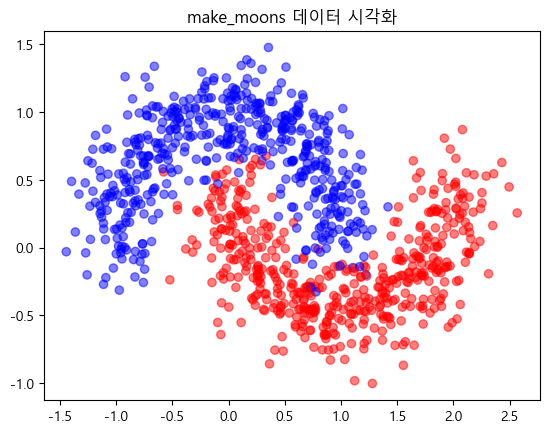

In [9]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", alpha=0.5)
plt.title("make_moons 데이터 시각화")
plt.show()

## 2. 학습 함수 정의

In [10]:
def train_logistic(X, y, epochs=50, lr=0.1, batch_size=None):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(X.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(X, y,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0,
                        validation_split=0.2)
    return history, model

## 3. Batch GD 학습 (전체 데이터 사용)

In [11]:
history_batch, model_batch = train_logistic(
    X_train, y_train, epochs=100, lr=0.1, batch_size=len(X_train)
)

## 4. Stochastic GD 학습 (batch_size=1)

In [12]:
history_sgd, model_sgd = train_logistic(
    X_train, y_train, epochs=100, lr=0.1, batch_size=1
)

## 5. Mini-batch GD 학습 (batch_size=32)

In [13]:
history_mini, model_mini = train_logistic(
    X_train, y_train, epochs=100, lr=0.1, batch_size=32
)

## 6. Loss 비교 시각화

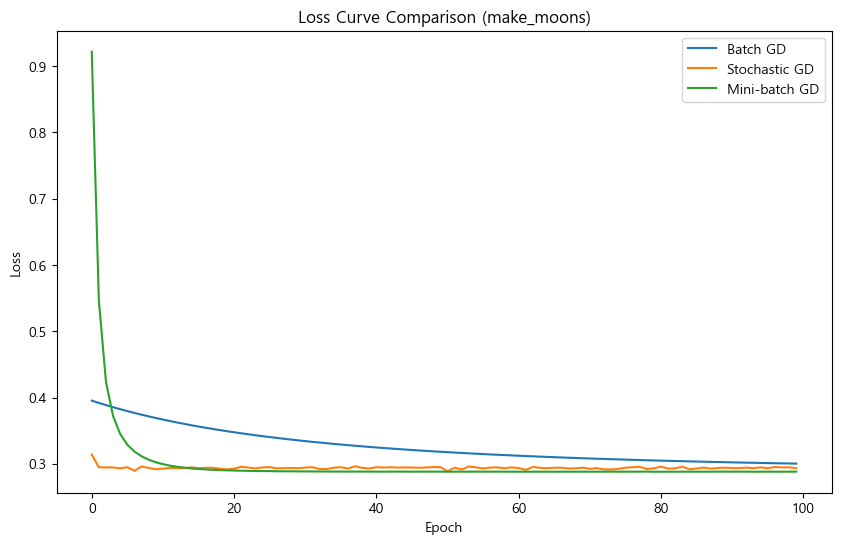

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history_batch.history["loss"], label="Batch GD")
plt.plot(history_sgd.history["loss"], label="Stochastic GD")
plt.plot(history_mini.history["loss"], label="Mini-batch GD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve Comparison (make_moons)")
plt.show()

## 7. 최종 정확도 비교

In [15]:
print("Batch GD 정확도:", model_batch.evaluate(X_test, y_test, verbose=0)[1])
print("Stochastic GD 정확도:", model_sgd.evaluate(X_test, y_test, verbose=0)[1])
print("Mini-batch GD 정확도:", model_mini.evaluate(X_test, y_test, verbose=0)[1])

Batch GD 정확도: 0.8600000143051147
Stochastic GD 정확도: 0.8650000095367432
Mini-batch GD 정확도: 0.8500000238418579


## 생각해보기
- 각 GD 방식의 장단점은 무엇일까요?

I. Batch Gradient Descent (배치 경사하강법) 
  1) 방식 : 매 업데이트 시 전체 데이터셋을 이용해 기울기(gradient) 계산 후 파라미터 업데이트
  2) 장점
    - 수렴 곡선이 매끄럽고 안정적 (잡음 없음)
    - 이론적으로 전역 최소값(Global minimum) (볼록 함수일 경우) 또는 좋은 해에 잘 도달
  3) 단점
    - 데이터셋이 크면 한 번의 업데이트 비용이 매우 큼 → 느림
    - 메모리에 전체 데이터를 올려야 해서 대규모 데이터셋에는 비효율적

II. Stochastic Gradient Descent (확률적 경사하강법, SGD)
  1) 방식 : 매 업데이트 시 하나의 샘플만 사용해 기울기 계산 후 파라미터 업데이트
  2) 장점
    - 업데이트가 매우 빠름 (즉각적인 학습)
    - 큰 데이터셋에서도 온라인 학습 가능
    - 지역 최소값(Local minimum)에서 탈출할 가능성이 높음 (잡음 효과)
  3) 단점
    - 손실 함수가 심하게 요동 → 수렴 경로 불안정
    - 학습률 조정이 까다로움 (너무 크면 발산, 너무 작으면 수렴 느림)
    - 수렴은 하지만 최적점 근처에서 계속 진동 가능

III. Mini-batch Gradient Descent (미니배치 경사하강법)
  1) 방식 : 매 업데이트 시 데이터의 일부(예: 32, 64, 128개) 를 사용
  2) 장점
    - Batch GD의 안정성 + SGD의 빠른 학습을 절충
    - 병렬 연산(GPU/TPU) 활용 최적화 → 딥러닝에서 표준
    - 적당한 노이즈 덕분에 지역 최소값 탈출 가능, 수렴도 비교적 안정
  3) 단점
    - 배치 크기 설정이 필요 (너무 작으면 요동 ↑, 너무 크면 Batch GD처럼 느려짐)
    - 하드웨어/데이터 특성에 따라 최적 배치 크기가 달라짐